TASK 1

FORECASTING FINANCIAL INSTRUMENTS PRICES
WITH VECM AND ARIMA MODELS

The aim of the project is to compare accuracy of forecasts of prices of two cointegrated financial
instruments with VECM model and two independent univariate ARIMA models.

Find one cointegrated pair out of ten provided time series. There is more than one cointegrated
pair but you are supposed to find just one of them. If you found more than one pair, you can
choose any of them for further analysis.
• Build a bivariate VECM model for the identified pair and produce forecasts of prices of two
instruments for the out-of-sample period.
• Find separately for two instruments the most attractive univariate ARIMA models and produce
forecasts for the same out-of-sample period.
• Compare accuracy of forecasts of the prices using the ex-post forecast error measures.
• Prepare a short report on it.

About the sample:
Please consider the in-sample period of 575 observations and out-of-sample period of 25 observations.
Detailed grading rules:
The maximum number of points you can get for the project is 40. Detailed grading rules are as follows:
• For checking the cointegration between the chosen time series – 6 pts.
• For estimating VECM, interpreting the estimates along with commenting on model’s diagnostics
and calculating forecasts – 12 pts.
• For applying the Box-Jenkins procedure in aim of choosing best possible ARIMA models’
specifications along with calculating forecasts for both series separately – 12 pts.
• For comparing VECM model’s forecasts with ARIMAs alternatives – 5 pts.
• For the structure, order, transparency and clarity of the provided report as well as for using a form
of Jupyter notebook – 5 pts.

In [184]:
#Load Dependencies
import pandas as pd # for data processing
import numpy as np # here mostly for series generation

import matplotlib.pyplot as plt # for vizualization
import matplotlib.dates as mdates # for data formatting when visualizing
import matplotlib.ticker as ticker # for more advanced axis formatting

import seaborn as sns


import statsmodels.api as sm # for linear regression model, OLS estimation
import statsmodels.stats.diagnostic as smd # for Breusch-Godfrey test

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR, VECM
from statsmodels.api import OLS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # ACF, PACF plots
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.vector_ar.vecm import select_order, select_coint_rank, coint_johansen
from statsmodels.stats.stattools import jarque_bera

from scipy.stats import norm

from IPython.display import Markdown

import yfinance as yf # for importing data directly from finance.yahoo.com

import warnings
warnings.simplefilter("ignore", category="UserWarning")
warnings.simplefilter("ignore", category="ValueWarning")

# Set global options
pd.options.display.float_format = '{:.10f}'.format
sns.set_theme(style="whitegrid")

# Set plotting style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings("ignore")

## Data Preparation

In [185]:
df = pd.read_csv('TSA_2025_project_data_1.csv')
#Define Spilt Sample
train_df = df.iloc[:575]
test_df = df.loc[575:]
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
print("head:")
print(df.head())

head:
                       y1             y2             y3             y4  \
date                                                                     
2023-09-09 109.4100000000 109.4100000000 109.4100000000 124.2400000000   
2023-09-10 109.4100000000 109.4100000000 109.4100000000 124.2100000000   
2023-09-11 109.4200000000 109.4100000000 109.4100000000 124.4100000000   
2023-09-12 108.6800000000 110.1900000000 111.1200000000 123.9300000000   
2023-09-13 106.2100000000 110.8800000000 112.9200000000 122.6800000000   

                       y5             y6             y7             y8  \
date                                                                     
2023-09-09 124.4700000000 109.4100000000 119.9400000000 104.6600000000   
2023-09-10 124.3200000000 109.4100000000 101.3900000000 104.3400000000   
2023-09-11 124.3700000000 109.4100000000  97.6400000000 104.2300000000   
2023-09-12 124.8200000000 109.4100000000  94.3500000000 107.2300000000   
2023-09-13 123.9100000000 107.8

In [186]:
print("dtypes:")
print(df.dtypes)

dtypes:
y1     float64
y2     float64
y3     float64
y4     float64
y5     float64
y6     float64
y7     float64
y8     float64
y9     float64
y10    float64
dtype: object


In [187]:
print("missing values:")
print(df.isnull().sum())

missing values:
y1     0
y2     0
y3     0
y4     0
y5     0
y6     0
y7     0
y8     0
y9     0
y10    0
dtype: int64


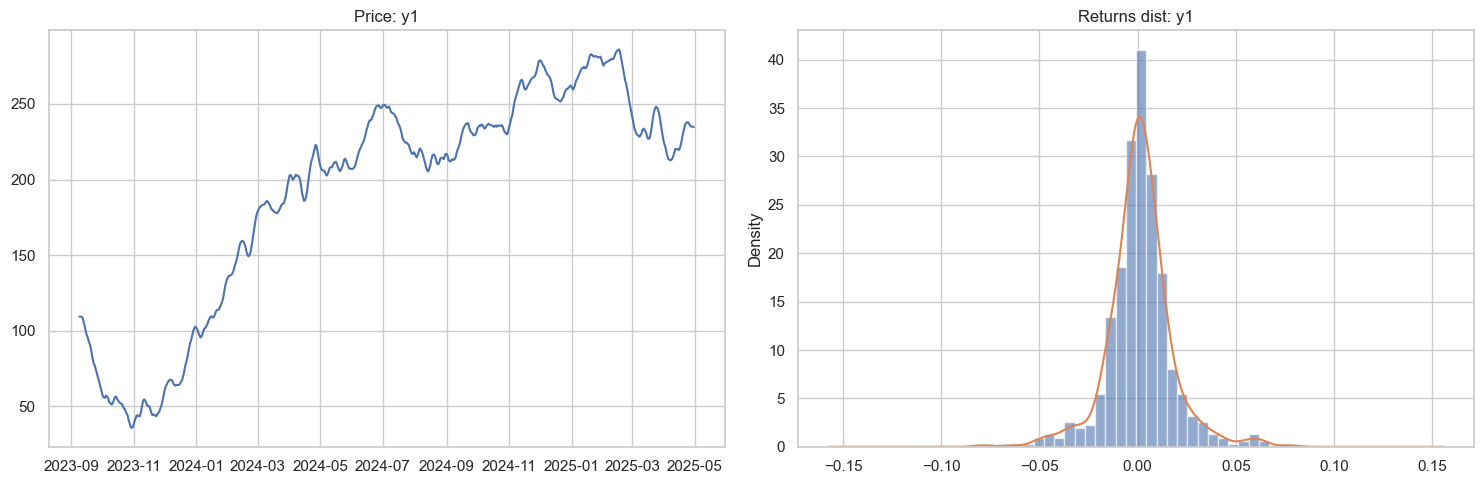

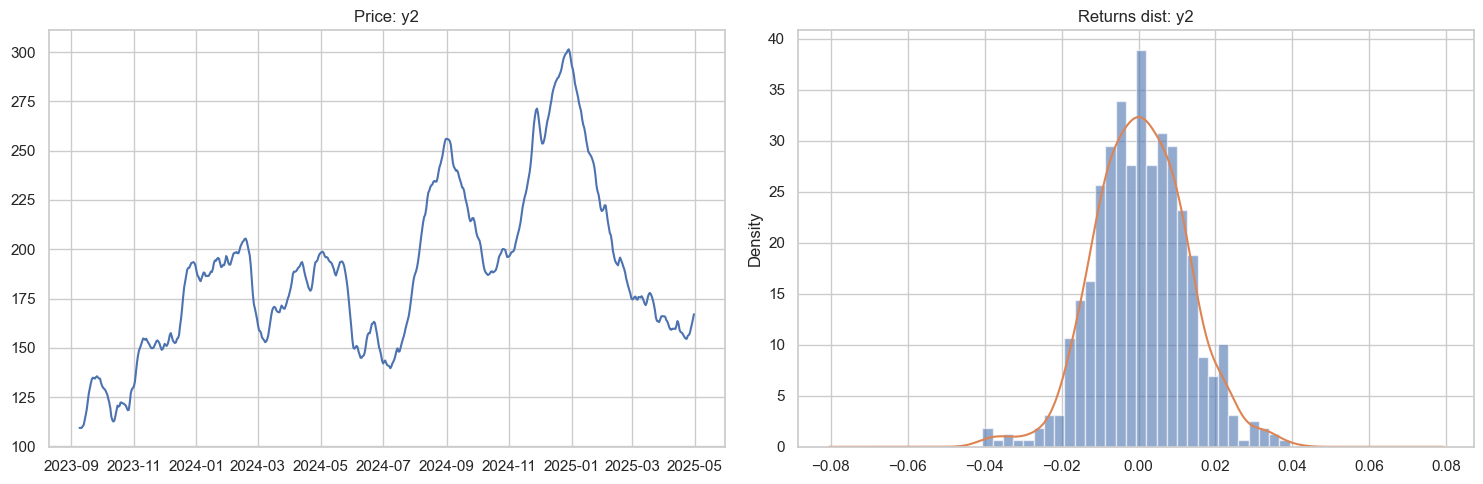

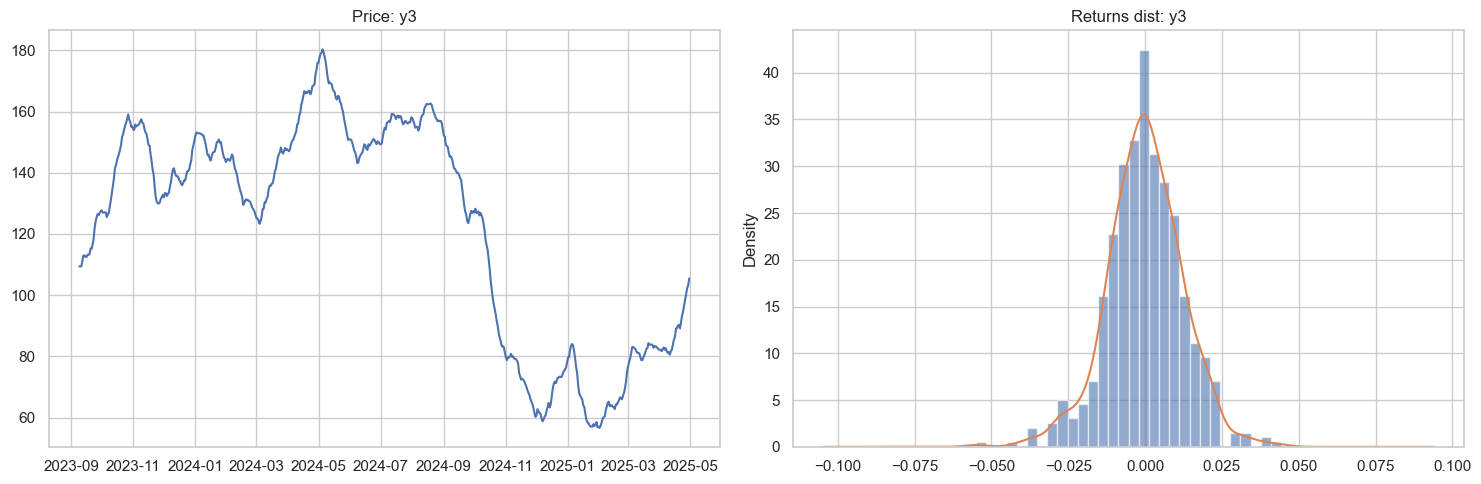

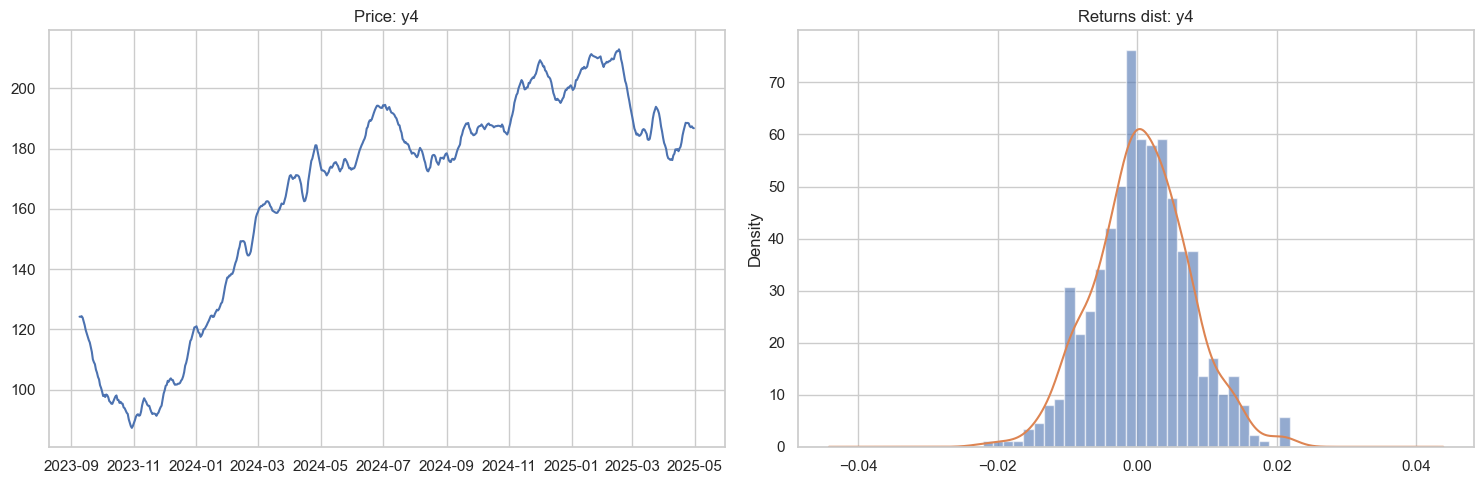

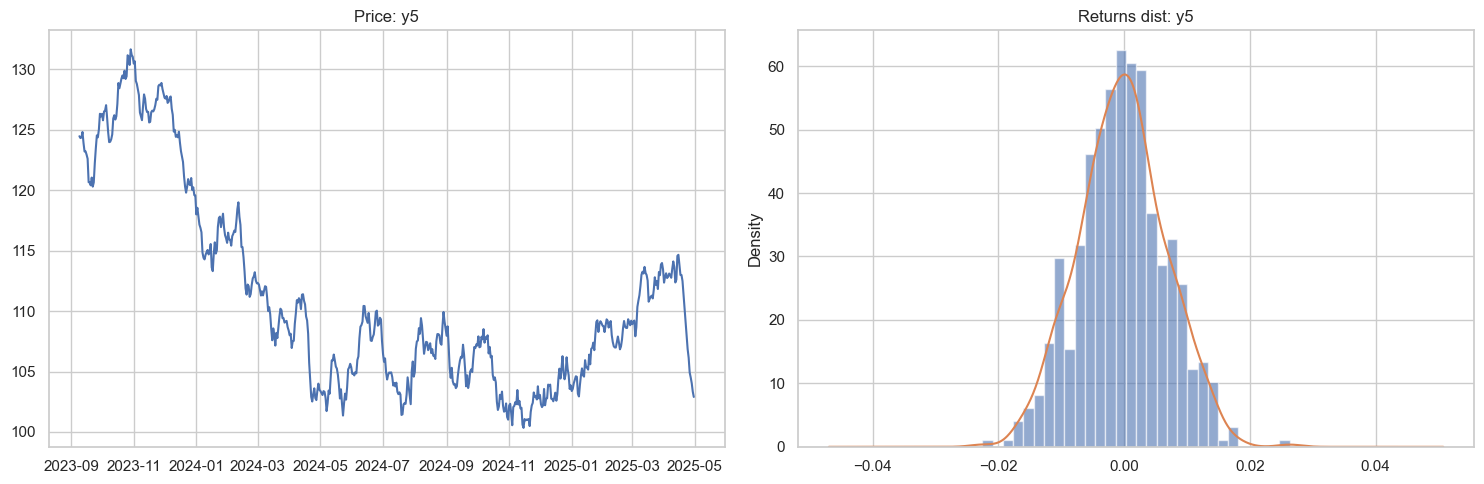

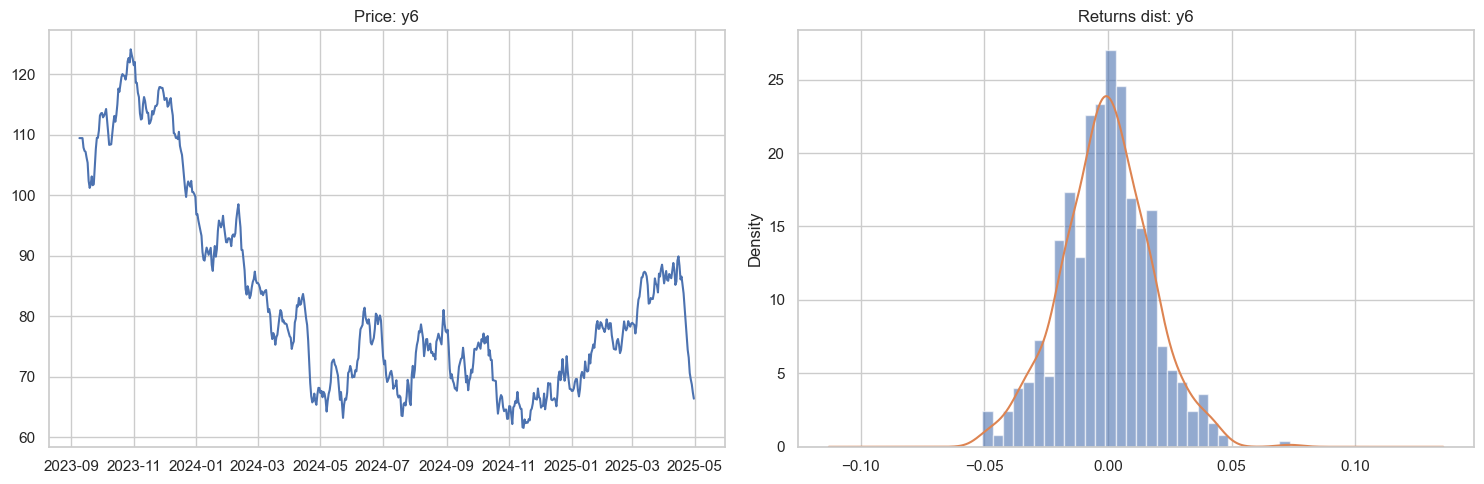

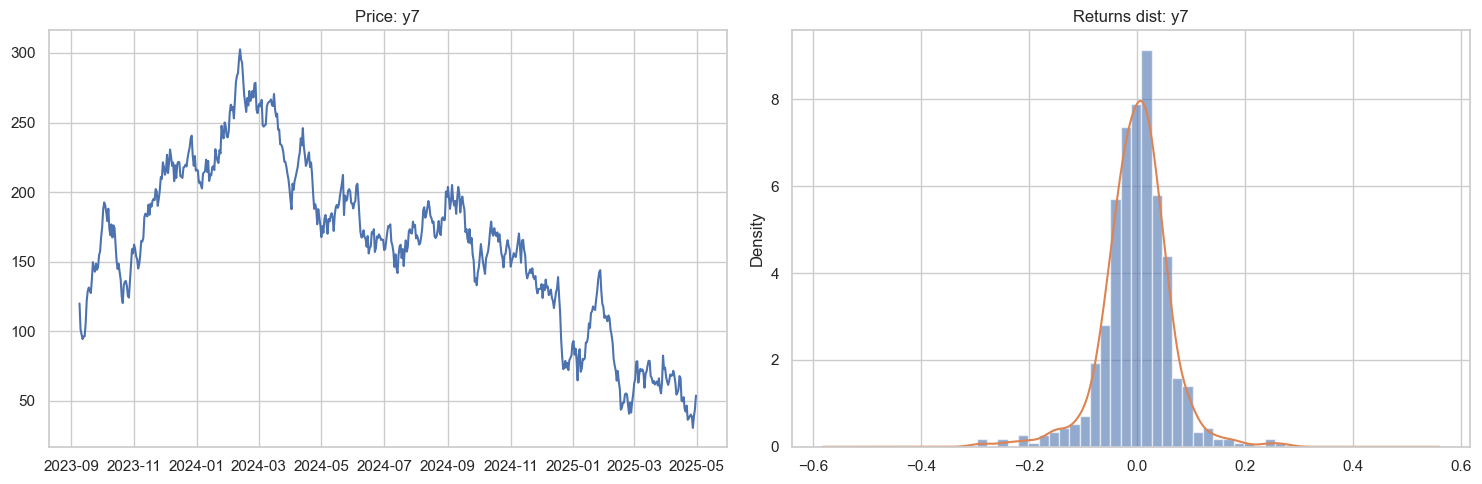

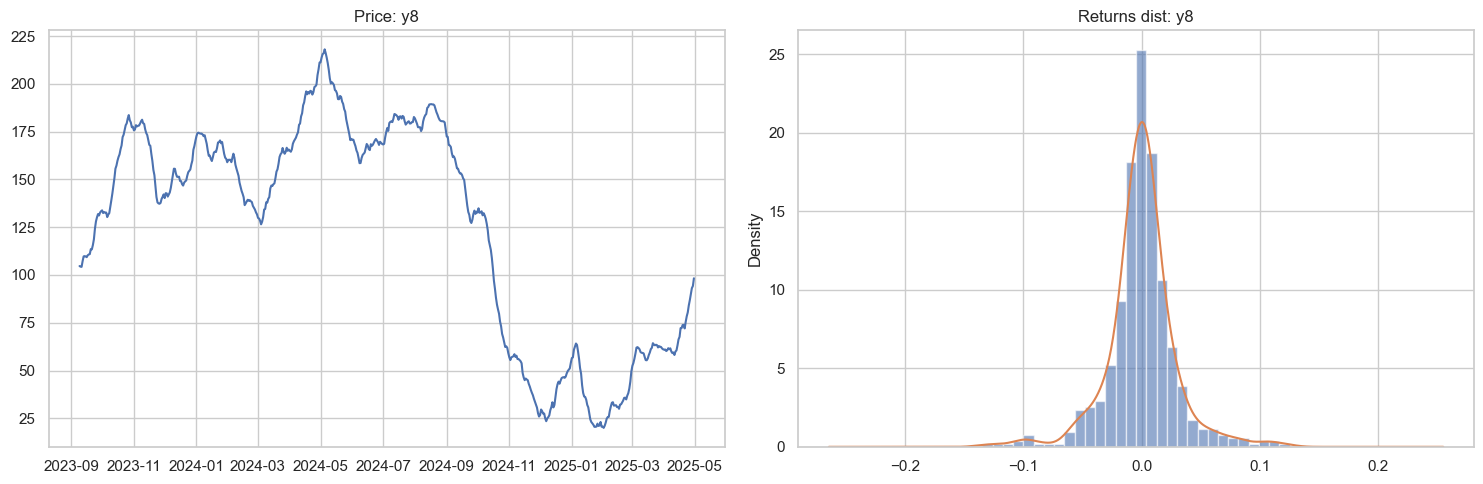

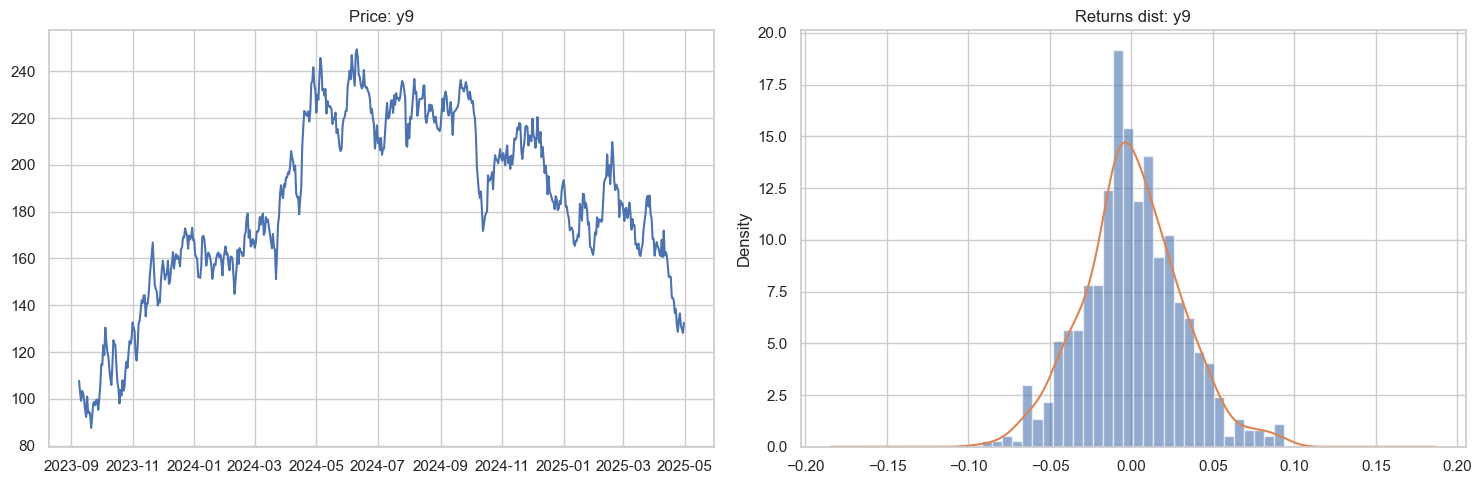

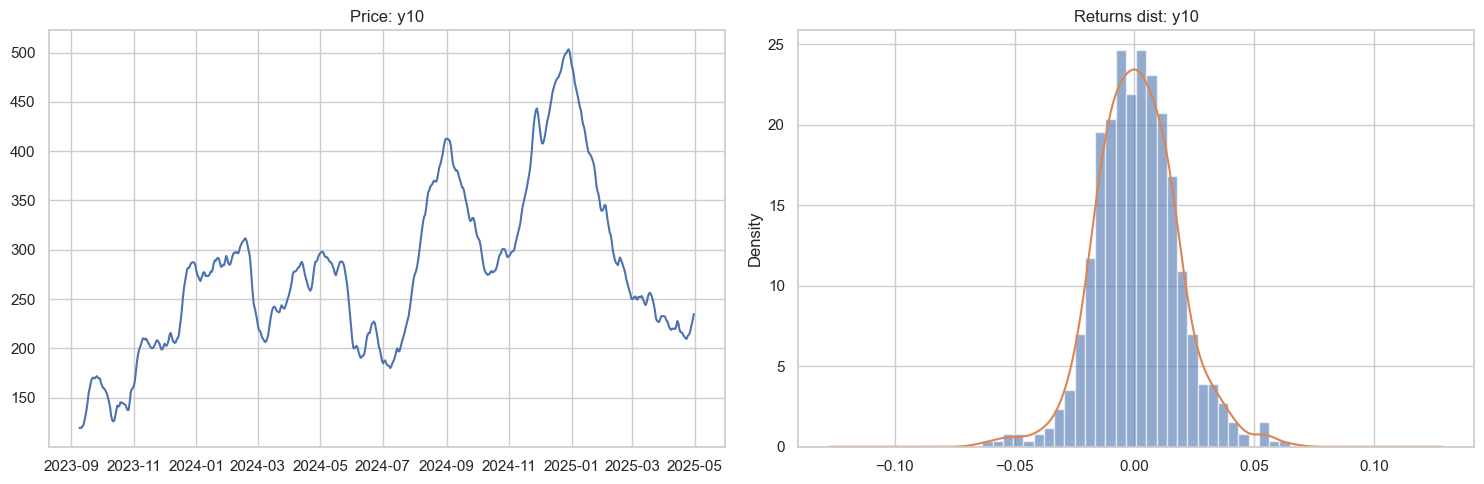

In [188]:
# Compute log-returns
returns = np.log(df) - np.log(df.shift(1))
returns = returns.dropna()

# Plot price vs returns
for col in df.columns:
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(df.index, df[col])
    plt.title(f'Price: {col}')
    plt.subplot(1,2,2)
    plt.hist(returns[col], bins=30, density=True, alpha=0.6)
    returns[col].plot(kind='kde')
    plt.title(f'Returns dist: {col}')
    plt.tight_layout()
    plt.show()

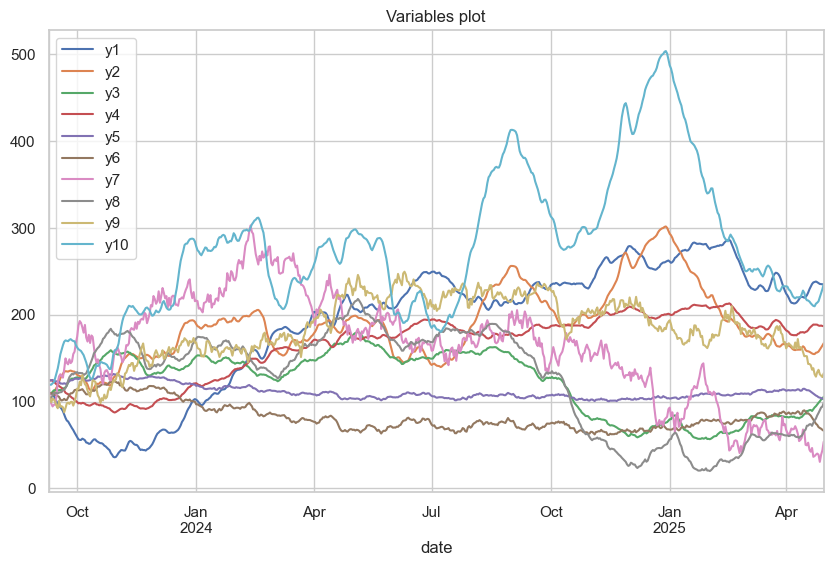

In [189]:
df[['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10']].plot(figsize=(10, 6), title="Variables plot")
plt.show()

With no test yet we can appreciete a similar tendency on the variables [y2 and y10], [y3 and y8] and [y5 and y6] 

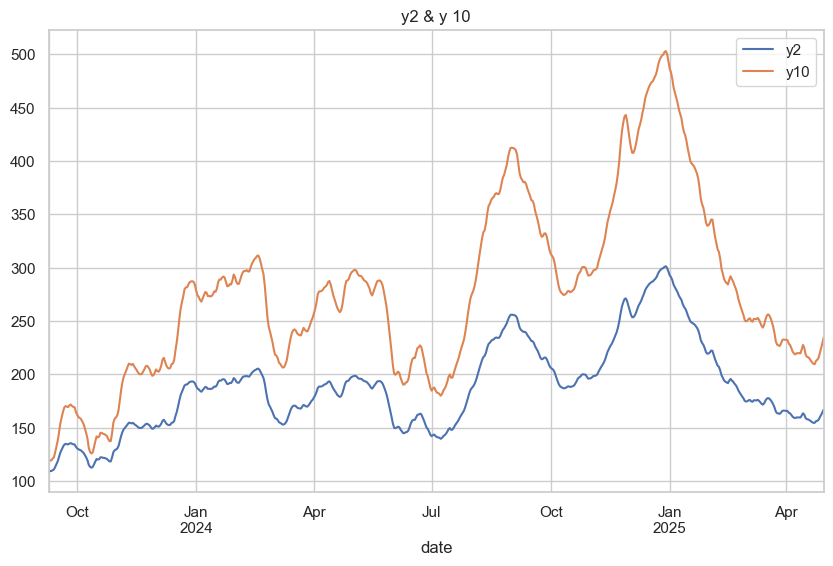

In [190]:
df[['y2','y10']].plot(figsize=(10, 6), title="y2 & y 10")
plt.show()

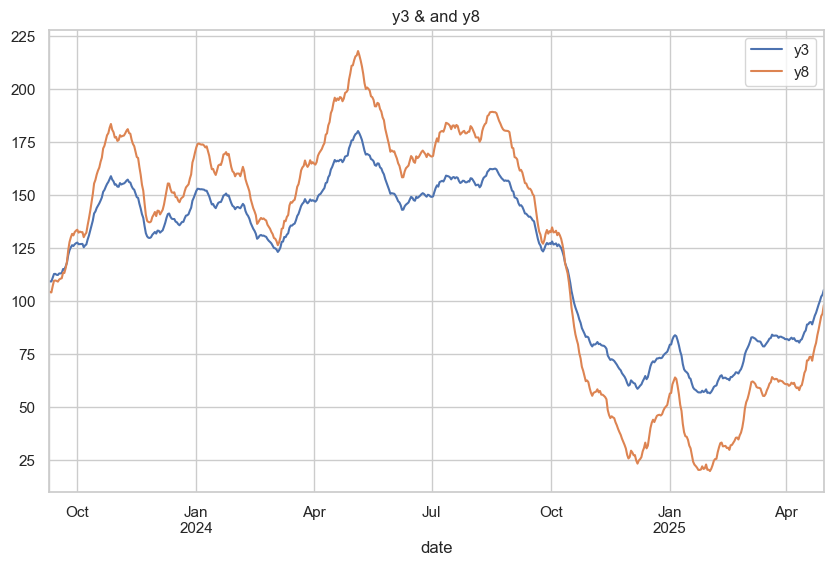

In [191]:
df[['y3', 'y8']].plot(figsize=(10, 6), title="y3 & and y8")
plt.show()

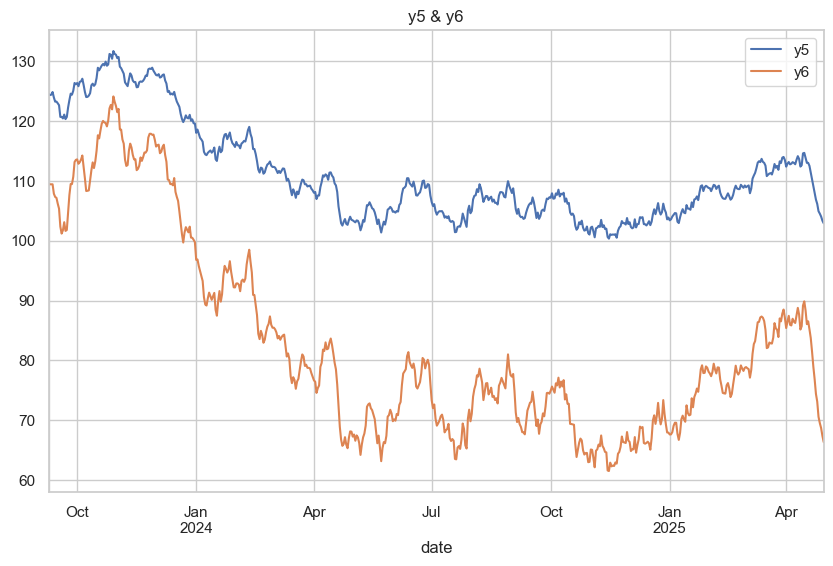

In [192]:
df[['y5', 'y6']].plot(figsize=(10, 6), title="y5 & y6")
plt.show()

In [193]:
diff_df = train_df[['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10']].diff()

for col in diff_df.columns:
    train_df[f'd{col}'] = diff_df[col]

In [194]:
train_df.head()

,date,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,dy1,dy2,dy3,dy4,dy5,dy6,dy7,dy8,dy9,dy10
0,2023-09-09,109.4100000000,109.4100000000,109.4100000000,124.2400000000,124.4700000000,109.4100000000,119.9400000000,104.6600000000,107.6200000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-09-10,109.4100000000,109.4100000000,109.4100000000,124.2100000000,124.3200000000,109.4100000000,101.3900000000,104.3400000000,102.6100000000,...,0.0000000000,0.0000000000,0.0000000000,-0.0300000000,-0.1500000000,0.0000000000,-18.5500000000,-0.3200000000,-5.0100000000,0.0400000000
2,2023-09-11,109.4200000000,109.4100000000,109.4100000000,124.4100000000,124.3700000000,109.4100000000,97.6400000000,104.2300000000,99.1600000000,...,0.0100000000,0.0000000000,0.0000000000,0.2000000000,0.0500000000,0.0000000000,-3.7500000000,-0.1100000000,-3.4500000000,0.0200000000
3,2023-09-12,108.6800000000,110.1900000000,111.1200000000,123.9300000000,124.8200000000,109.4100000000,94.3500000000,107.2300000000,103.3900000000,...,-0.7400000000,0.7800000000,1.7100000000,-0.4800000000,0.4500000000,0.0000000000,-3.2900000000,3.0000000000,4.2300000000,1.6800000000
4,2023-09-13,106.2100000000,110.8800000000,112.9200000000,122.6800000000,123.9100000000,107.8400000000,96.2200000000,109.7100000000,102.4300000000,...,-2.4700000000,0.6900000000,1.8000000000,-1.2500000000,-0.9100000000,-1.5700000000,1.8700000000,2.4800000000,-0.9600000000,1.1100000000


## 1. Test for Cointegration

In [195]:
def adf_test(series, max_lag=5):
    result = adfuller(series.dropna(), maxlag=max_lag, autolag=None)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[0] < result[4]["5%"]:
        print ("Reject Ho - Time Series is Stationary")
    else:
        print ("Failed to Reject Ho - Time Series is Non-Stationary")

In [196]:
X = train_df["y2"].values
adf_test(df["y2"])

ADF Statistic: -2.384781
p-value: 0.146078
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
Failed to Reject Ho - Time Series is Non-Stationary


In [197]:
X = train_df["y10"].values
adf_test(train_df["y10"])

ADF Statistic: -2.250023
p-value: 0.188593
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569
Failed to Reject Ho - Time Series is Non-Stationary


In [198]:
X = train_df["dy2"].values
adf_test(train_df["dy2"])

ADF Statistic: -6.574744
p-value: 0.000000
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569
Reject Ho - Time Series is Stationary


In [199]:
X = train_df["dy10"].values
adf_test(train_df["dy10"])

ADF Statistic: -6.511367
p-value: 0.000000
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569
Reject Ho - Time Series is Stationary


Both variables are $\sim I(1)$, so in the next step we can check whether they are **cointegrated**.

In [200]:
def adf_test(series, max_aug=10, version='c'):
    
    results = []

    y = series.diff()
    X = pd.DataFrame({'y_lag': series.shift()})

    if version == 'c' or version == 't': # constant to be added optionally 
        X = sm.add_constant(X)
    if version == 't': # (deterministic) trend component to be added optionally
        X['trend'] = range(len(X))

    for i in range(0, max_aug): # iterating through different numbers of augmentations
        
        for aug in range(1, i+1): # adding augmentations max_aug is reached
            X['aug_'+str(aug)] = y.shift(aug)

        model = sm.OLS(series.diff(), X, missing='drop').fit() # fitting a linear regression with OLS

        ts = model.tvalues['y_lag'] # test statistic
        nobs = model.nobs # number of observations

        if version == 'n': # critical values for basic version of ADF
            if nobs > 100:
                cv01 = -2.567; cv05 = -1.941; cv10 = -1.616 # critical values for more than 500 observations
            else:
                cv01 = np.nan; cv05 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually
        if version == 'c': # critical values for version with constant
            if nobs > 100:
                cv01 = -3.434; cv05 = -2.863; cv10 = -2.568 # critical values for more than 500 observations
            else:
                cv01 = np.nan; cv05 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually
        if version == 't': # critical values for version with constant and (deterministic) trend component
            if nobs > 100:
                cv01 = -3.963; cv05 = -3.413; cv10 = -3.128 # critical values for more than 500 observations
            else:
                cv01 = np.nan; cv05 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually

        bg_test01 = smd.acorr_breusch_godfrey(model, nlags=1);  bg_pvalue01 = round(bg_test01[1],4); bg_test01 = round(bg_test01[0],4); 
        bg_test05 = smd.acorr_breusch_godfrey(model, nlags=5);  bg_pvalue05 = round(bg_test05[1],4); bg_test05 = round(bg_test05[0],4); 
        bg_test10 = smd.acorr_breusch_godfrey(model, nlags=10); bg_pvalue10 = round(bg_test10[1],4); bg_test10 = round(bg_test10[0],4);
        bg_test15 = smd.acorr_breusch_godfrey(model, nlags=15); bg_pvalue15 = round(bg_test15[1],4); bg_test15 = round(bg_test15[0],4);

        results.append([i, ts, cv01, cv05, cv10, 
                        bg_test01, bg_pvalue01, bg_test05, bg_pvalue05, bg_test10, bg_pvalue10, bg_test15, bg_pvalue15])

    results_df = pd.DataFrame(results)
    results_df.columns = ['number of augmentations', 
                          'ADF test statistic', 'ADF critival value (1%)', 'ADF critival value (5%)', 'ADF critival value (10%)', 
                          'BG test (1 lag) (statistic)', 'BG test (1 lag) (p-value)', 
                          'BG test (5 lags) (statistic)', 'BG test (5 lags) (p-value)', 
                          'BG test (10 lags) (statistic)', 'BG test (10 lags) (p-value)', 
                          'BG test (15 lags) (statistic)', 'BG test (15 lags) (p-value)']
    
    return results_df

In [201]:
adf_test(train_df['y2'])

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.8822597171,-3.4340000000,-2.8630000000,-2.5680000000,425.7181000000,0.0000000000,449.7069000000,0.0000000000,452.5615000000,0.0000000000,453.1616000000,0.0000000000
1,1,-2.6157603140,-3.4340000000,-2.8630000000,-2.5680000000,47.3642000000,0.0000000000,97.9047000000,0.0000000000,102.8077000000,0.0000000000,104.6629000000,0.0000000000
2,2,-2.1496364941,-3.4340000000,-2.8630000000,-2.5680000000,26.6086000000,0.0000000000,57.3745000000,0.0000000000,60.4578000000,0.0000000000,62.2334000000,0.0000000000
3,3,-2.4049360991,-3.4340000000,-2.8630000000,-2.5680000000,12.3845000000,0.0004000000,33.3642000000,0.0000000000,38.7658000000,0.0000000000,40.0410000000,0.0004000000
4,4,-2.1935056626,-3.4340000000,-2.8630000000,-2.5680000000,12.8349000000,0.0003000000,25.2678000000,0.0001000000,30.1459000000,0.0008000000,31.6027000000,0.0073000000
5,5,-2.2673831114,-3.4340000000,-2.8630000000,-2.5680000000,5.9263000000,0.0149000000,12.6567000000,0.0268000000,16.7567000000,0.0799000000,17.6630000000,0.2808000000
6,6,-2.0950562734,-3.4340000000,-2.8630000000,-2.5680000000,2.4646000000,0.1164000000,3.1010000000,0.6844000000,8.1404000000,0.6151000000,9.6346000000,0.8421000000
7,7,-2.1268162270,-3.4340000000,-2.8630000000,-2.5680000000,0.0088000000,0.9254000000,4.4085000000,0.4922000000,6.5432000000,0.7677000000,8.2050000000,0.9153000000
8,8,-2.0161896703,-3.4340000000,-2.8630000000,-2.5680000000,0.0003000000,0.9869000000,0.2940000000,0.9978000000,8.5821000000,0.5722000000,10.2659000000,0.8027000000
9,9,-2.0628662544,-3.4340000000,-2.8630000000,-2.5680000000,0.7748000000,0.3787000000,4.3188000000,0.5045000000,6.0732000000,0.8091000000,9.5162000000,0.8490000000


In [202]:
adf_test(train_df['y10'])

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.8841970367,-3.4340000000,-2.8630000000,-2.5680000000,424.8320000000,0.0000000000,446.6175000000,0.0000000000,448.9251000000,0.0000000000,449.7937000000,0.0000000000
1,1,-2.6105197595,-3.4340000000,-2.8630000000,-2.5680000000,44.9137000000,0.0000000000,87.3367000000,0.0000000000,91.9624000000,0.0000000000,94.8094000000,0.0000000000
2,2,-2.1572125995,-3.4340000000,-2.8630000000,-2.5680000000,23.4591000000,0.0000000000,47.4175000000,0.0000000000,51.3834000000,0.0000000000,54.0694000000,0.0000000000
3,3,-2.3880321292,-3.4340000000,-2.8630000000,-2.5680000000,10.0651000000,0.0015000000,26.0485000000,0.0001000000,33.1850000000,0.0003000000,35.2355000000,0.0023000000
4,4,-2.2158434286,-3.4340000000,-2.8630000000,-2.5680000000,11.4985000000,0.0007000000,20.5542000000,0.0010000000,27.1344000000,0.0025000000,29.5367000000,0.0137000000
5,5,-2.2500225144,-3.4340000000,-2.8630000000,-2.5680000000,4.5137000000,0.0336000000,9.3863000000,0.0946000000,14.2728000000,0.1609000000,16.4127000000,0.3552000000
6,6,-2.1211851993,-3.4340000000,-2.8630000000,-2.5680000000,1.4136000000,0.2345000000,2.0948000000,0.8359000000,8.5889000000,0.5715000000,11.1112000000,0.7447000000
7,7,-2.1000681212,-3.4340000000,-2.8630000000,-2.5680000000,0.2525000000,0.6153000000,4.1009000000,0.5350000000,8.0809000000,0.6209000000,11.1190000000,0.7441000000
8,8,-2.0400696030,-3.4340000000,-2.8630000000,-2.5680000000,0.7993000000,0.3713000000,1.5940000000,0.9020000000,9.9952000000,0.4409000000,13.3483000000,0.5754000000
9,9,-2.0439985379,-3.4340000000,-2.8630000000,-2.5680000000,0.3369000000,0.5616000000,4.3649000000,0.4982000000,7.0440000000,0.7213000000,12.7791000000,0.6194000000


In [203]:
adf_test(train_df['dy2'])

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-6.5264261015,-3.4340000000,-2.8630000000,-2.5680000000,49.4347000000,0.0000000000,99.4710000000,0.0000000000,103.8406000000,0.0000000000,105.6099000000,0.0000000000
1,1,-8.5108319450,-3.4340000000,-2.8630000000,-2.5680000000,25.1371000000,0.0000000000,56.5251000000,0.0000000000,60.2453000000,0.0000000000,61.8927000000,0.0000000000
2,2,-6.4547703190,-3.4340000000,-2.8630000000,-2.5680000000,13.2432000000,0.0003000000,34.6242000000,0.0000000000,39.2896000000,0.0000000000,40.3723000000,0.0004000000
3,3,-7.2512492577,-3.4340000000,-2.8630000000,-2.5680000000,11.4218000000,0.0007000000,22.4273000000,0.0004000000,28.7420000000,0.0014000000,31.1664000000,0.0083000000
4,4,-6.0530363178,-3.4340000000,-2.8630000000,-2.5680000000,5.8534000000,0.0155000000,13.4716000000,0.0193000000,16.9595000000,0.0753000000,17.6737000000,0.2802000000
5,5,-6.5747441997,-3.4340000000,-2.8630000000,-2.5680000000,1.9583000000,0.1617000000,3.0217000000,0.6966000000,7.6603000000,0.6620000000,8.9673000000,0.8792000000
6,6,-5.9884128035,-3.4340000000,-2.8630000000,-2.5680000000,0.0331000000,0.8557000000,4.5996000000,0.4667000000,6.3734000000,0.7830000000,7.6892000000,0.9356000000
7,7,-5.9705493783,-3.4340000000,-2.8630000000,-2.5680000000,0.0100000000,0.9202000000,0.2143000000,0.9990000000,7.7447000000,0.6538000000,9.3393000000,0.8591000000
8,8,-5.5150496553,-3.4340000000,-2.8630000000,-2.5680000000,0.3905000000,0.5320000000,4.0894000000,0.5366000000,5.3505000000,0.8666000000,8.0173000000,0.9231000000
9,9,-5.0597388737,-3.4340000000,-2.8630000000,-2.5680000000,0.8463000000,0.3576000000,2.4249000000,0.7878000000,4.0264000000,0.9461000000,6.0733000000,0.9785000000


In [204]:
adf_test(train_df['dy10'])

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-6.5498339355,-3.4340000000,-2.8630000000,-2.5680000000,46.9409000000,0.0000000000,88.8667000000,0.0000000000,92.9935000000,0.0000000000,95.7079000000,0.0000000000
1,1,-8.4691134007,-3.4340000000,-2.8630000000,-2.5680000000,22.0677000000,0.0000000000,46.3786000000,0.0000000000,51.0895000000,0.0000000000,53.4932000000,0.0000000000
2,2,-6.5175642444,-3.4340000000,-2.8630000000,-2.5680000000,10.8611000000,0.0010000000,27.2425000000,0.0001000000,33.6782000000,0.0002000000,35.5019000000,0.0021000000
3,3,-7.2005973366,-3.4340000000,-2.8630000000,-2.5680000000,10.1311000000,0.0015000000,19.0368000000,0.0019000000,24.3167000000,0.0068000000,29.3831000000,0.0144000000
4,4,-6.1030210775,-3.4340000000,-2.8630000000,-2.5680000000,4.3882000000,0.0362000000,10.1735000000,0.0705000000,14.5389000000,0.1498000000,16.4982000000,0.3497000000
5,5,-6.5113665233,-3.4340000000,-2.8630000000,-2.5680000000,1.0206000000,0.3124000000,2.1472000000,0.8284000000,8.1432000000,0.6148000000,10.5545000000,0.7835000000
6,6,-6.0714771785,-3.4340000000,-2.8630000000,-2.5680000000,0.3530000000,0.5524000000,4.3293000000,0.5030000000,7.7331000000,0.6549000000,10.3859000000,0.7948000000
7,7,-5.9345210003,-3.4340000000,-2.8630000000,-2.5680000000,0.7358000000,0.3910000000,1.5559000000,0.9065000000,9.2835000000,0.5054000000,12.5279000000,0.6387000000
8,8,-5.5690146782,-3.4340000000,-2.8630000000,-2.5680000000,0.0832000000,0.7730000000,5.0274000000,0.4125000000,5.9377000000,0.8205000000,11.0986000000,0.7456000000
9,9,-5.0118793968,-3.4340000000,-2.8630000000,-2.5680000000,1.5562000000,0.2122000000,3.6003000000,0.6083000000,6.1205000000,0.8050000000,7.4279000000,0.9447000000


Once again we can see that the variables are integrated of order 1, no autocorrelation in residuals from 5 augmentations

To estimating the cointegrating vector, we will estimate the following model:

In [205]:
model_coint = OLS(train_df['y2'], np.column_stack((np.ones(len(train_df)), train_df['y10']))).fit()

In [206]:
print(model_coint.summary())

                            OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.386e+08
Date:                Mon, 26 May 2025   Prob (F-statistic):               0.00
Time:                        17:15:07   Log-Likelihood:                 924.52
No. Observations:                 575   AIC:                            -1845.
Df Residuals:                     573   BIC:                            -1836.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.6951      0.007   7134.319      0.0

In [207]:
beta = model_coint.params
print(f"beta.const: {beta.const:.4f}")

beta.const: 49.6951


In [208]:
# Test stationarity of residuals
residuals = model_coint.resid
adf_test(pd.Series(residuals))

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-24.0445796757,-3.4340000000,-2.8630000000,-2.5680000000,0.2826000000,0.5950000000,4.7958000000,0.4413000000,7.1766000000,0.7087000000,14.6780000000,0.4749000000
1,1,-16.2518209716,-3.4340000000,-2.8630000000,-2.5680000000,0.3555000000,0.5510000000,4.4236000000,0.4902000000,6.6004000000,0.7626000000,14.5325000000,0.4856000000
2,2,-13.9834050589,-3.4340000000,-2.8630000000,-2.5680000000,-1.6957000000,1.0000000000,6.2373000000,0.2838000000,9.8001000000,0.4582000000,17.0236000000,0.3175000000
3,3,-12.7346917455,-3.4340000000,-2.8630000000,-2.5680000000,-2.2757000000,1.0000000000,6.8930000000,0.2287000000,9.4135000000,0.4934000000,17.0891000000,0.3136000000
4,4,-11.0323176443,-3.4340000000,-2.8630000000,-2.5680000000,0.0188000000,0.8909000000,3.7726000000,0.5826000000,6.5410000000,0.7679000000,13.7206000000,0.5468000000
5,5,-10.0312739174,-3.4340000000,-2.8630000000,-2.5680000000,0.7200000000,0.3961000000,3.7393000000,0.5875000000,11.0058000000,0.3571000000,18.8154000000,0.2222000000
6,6,-9.0909815580,-3.4340000000,-2.8630000000,-2.5680000000,1.5972000000,0.2063000000,2.9484000000,0.7079000000,10.2575000000,0.4182000000,17.2168000000,0.3061000000
7,7,-8.5232972300,-3.4340000000,-2.8630000000,-2.5680000000,0.2962000000,0.5863000000,6.6141000000,0.2510000000,10.2254000000,0.4209000000,18.1742000000,0.2536000000
8,8,-8.4914186118,-3.4340000000,-2.8630000000,-2.5680000000,-1.0726000000,1.0000000000,4.5319000000,0.4756000000,17.2260000000,0.0695000000,22.4496000000,0.0965000000
9,9,-8.1375389518,-3.4340000000,-2.8630000000,-2.5680000000,0.5711000000,0.4498000000,4.7698000000,0.4446000000,16.5225000000,0.0856000000,18.9631000000,0.2154000000


Non-stationarity of residuals is rejected with no augmentations, therefore the residuals are stationarity and y2 and y10 are cointegrated

In [209]:
Markdown(f"The cointegrating vector is [1, -{beta.const:.3f}, -{beta.x1:.3f}]. This defines the cointegrating relationship as: 1 * y2 = -{beta.const:.3f} - {beta.x1:.3f} * y10.")

The cointegrating vector is [1, -49.695, -0.500]. This defines the cointegrating relationship as: 1 * y2 = -49.695 - 0.500 * y10.

## ARIMA Box-Jenkins Procedure

In [210]:
coint_df = train_df[['y2', 'y10']].copy()
coint_test_df = test_df[['y2', 'y10']].copy()

coint_df['dy2'] = coint_df['y2'].diff()
coint_df['dy10'] = coint_df['y10'].diff()

dy2_clean = coint_df['dy2'].dropna()
dy10_clean = coint_df['dy10'].dropna()


coint_df.head()

,y2,y10,dy2,dy10
0,109.4100000000,119.3200000000,NaN,NaN
1,109.4100000000,119.3600000000,0.0000000000,0.0400000000
2,109.4100000000,119.3800000000,0.0000000000,0.0200000000
3,110.1900000000,121.0600000000,0.7800000000,1.6800000000
4,110.8800000000,122.1700000000,0.6900000000,1.1100000000


### 2.1. Step 1: initial identification of ARIMA orders

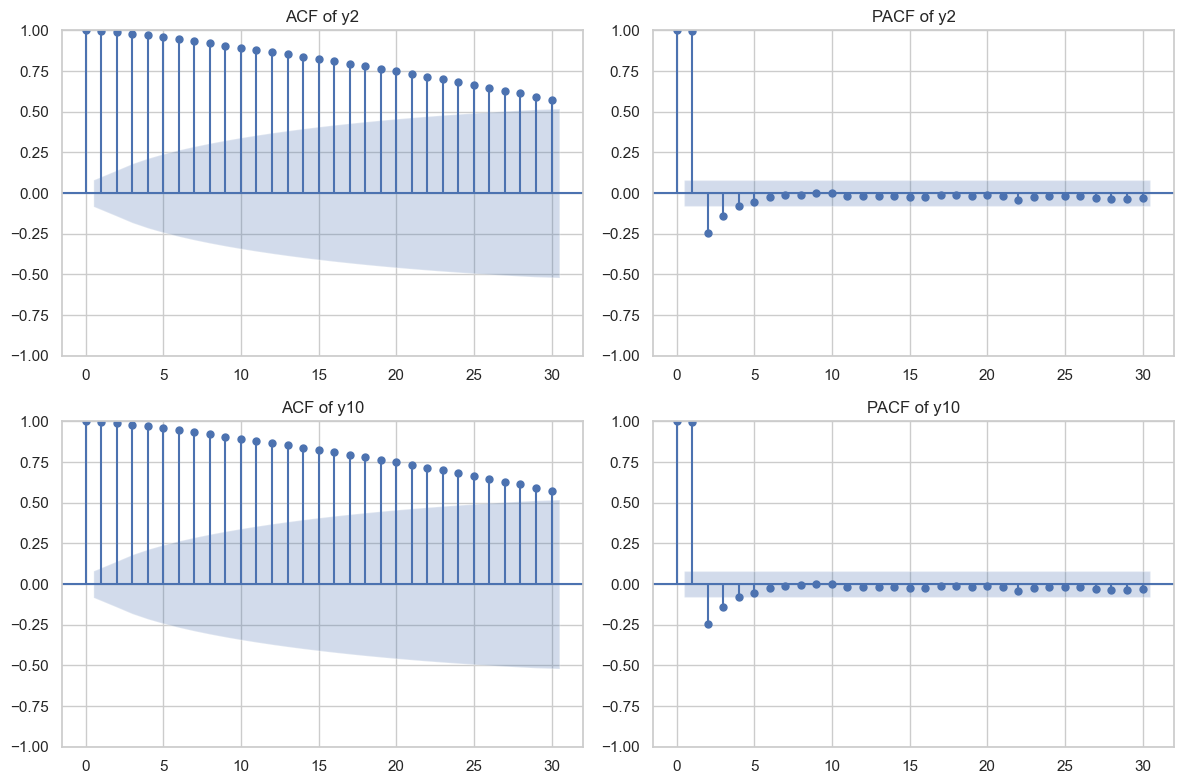

In [211]:
#ACF and PACF raw series
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Row 0 ─ y2 (level)
plot_acf(coint_df['y2'],  lags=30, ax=axes[0, 0])
axes[0, 0].set_title('ACF of y2')

plot_pacf(coint_df['y2'], lags=30, ax=axes[0, 1])
axes[0, 1].set_title('PACF of y2')

# Row 1 ─ y10 (level)
plot_acf(coint_df['y10'],  lags=30, ax=axes[1, 0])
axes[1, 0].set_title('ACF of y10')

plot_pacf(coint_df['y10'], lags=30, ax=axes[1, 1])
axes[1, 1].set_title('PACF of y10')

fig.tight_layout()
plt.show()

The series is ~ I(1). Therefore for ARIMA(p,d,q), d=1. Let us determine the initial values of p and q. For this purpose, we should consider ACF and PACF of the differences (as they are stationary).

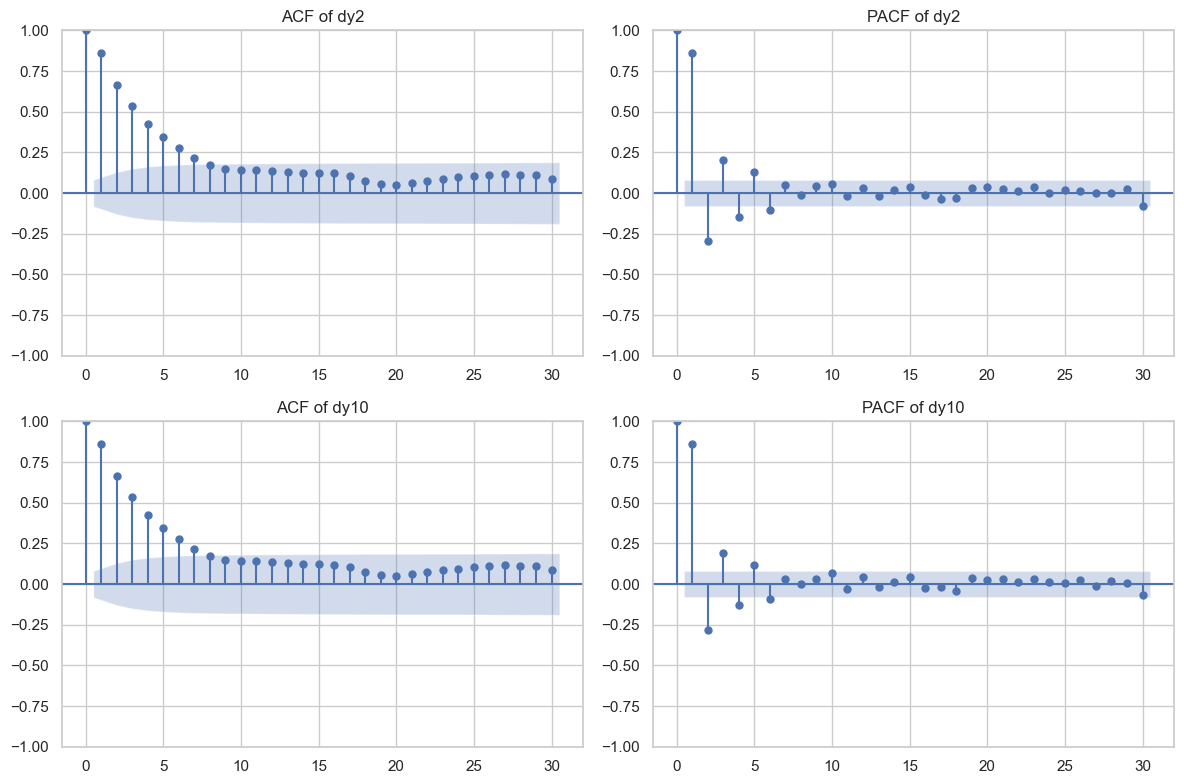

In [212]:
#ACF and PACF differenced series

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Row 0 ─ dy2
plot_acf(dy2_clean,  lags=30, ax=axes[0, 0])
axes[0, 0].set_title('ACF of dy2')

plot_pacf(dy2_clean, lags=30, ax=axes[0, 1])
axes[0, 1].set_title('PACF of dy2')

# Row 1 ─ dy10
plot_acf(dy10_clean,  lags=30, ax=axes[1, 0])
axes[1, 0].set_title('ACF of dy10')

plot_pacf(dy10_clean, lags=30, ax=axes[1, 1])
axes[1, 1].set_title('PACF of dy10')

fig.tight_layout()           # neat spacing
plt.show()

# Y2 ARIMA Models

ACF is decaying exponetially as expected, the PCF spike at 1 then drop off, suggests AR order 1.
so we will start by fitting 
## ARIMA (1,1,0).

In [213]:
model = ARIMA(coint_df['y2'].values, order = (1,1,0))
arima_110_y2 = model.fit()
print(arima_110_y2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  575
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -884.315
Date:                Mon, 26 May 2025   AIC                           1772.629
Time:                        17:15:10   BIC                           1781.335
Sample:                             0   HQIC                          1776.025
                                - 575                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8595      0.020     42.935      0.000       0.820       0.899
sigma2         1.2725      0.073     17.420      0.000       1.129       1.416
Ljung-Box (L1) (Q):                  37.10   Jarque-

The z value for AR(1) is highly siginificant with p = 0.000, indicating good fit. However the LJBox test at prob(Q) = 0.00 suggests residuals may still be autocorrelated.

In [214]:
ljung_test = acorr_ljungbox(arima_110_y2.resid, lags=[1,5, 10, 15, 20, 25], return_df=True)
print(ljung_test)

        lb_stat    lb_pvalue
1  0.1214753411 0.7274398392
5  0.3176772866 0.9972973405
10 0.4715751653 0.9999950073
15 0.5790702403 0.9999999949
20 0.7158930255 1.0000000000
25 0.9234232561 1.0000000000


Residuals seem to be white noise

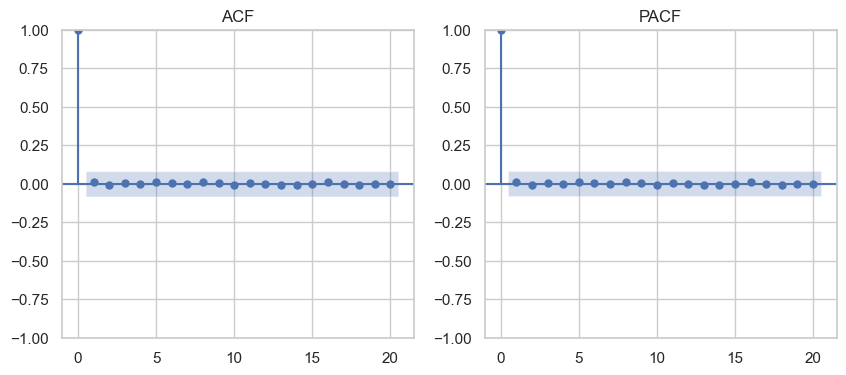

In [215]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

plot_acf(arima_110_y2.resid, lags=20, ax=axes[0]) 
axes[0].set_title("ACF")

plot_pacf(arima_110_y2.resid, lags=20, ax=axes[1]) 
axes[1].set_title("PACF")

plt.show()

# ARIMA(0,1,1)

In [216]:
model = ARIMA(coint_df['y2'].values, order = (0,1,1))
arima_011_y2 = model.fit()
print(arima_011_y2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  575
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -986.586
Date:                Mon, 26 May 2025   AIC                           1977.172
Time:                        17:15:11   BIC                           1985.877
Sample:                             0   HQIC                          1980.568
                                - 575                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.8760      0.019     45.317      0.000       0.838       0.914
sigma2         1.8170      0.105     17.263      0.000       1.611       2.023
Ljung-Box (L1) (Q):                 164.48   Jarque-

In [217]:
ljung_test = acorr_ljungbox(arima_011_y2.resid, lags=[1,5, 10, 15, 20, 25], return_df=True)
print(ljung_test)

        lb_stat    lb_pvalue
1  1.0415619369 0.3074584848
5  4.2010883175 0.5208424196
10 6.1734670527 0.8004847496
15 6.7684086156 0.9637603831
20 6.8751160340 0.9970749603
25 7.0285218734 0.9998447036


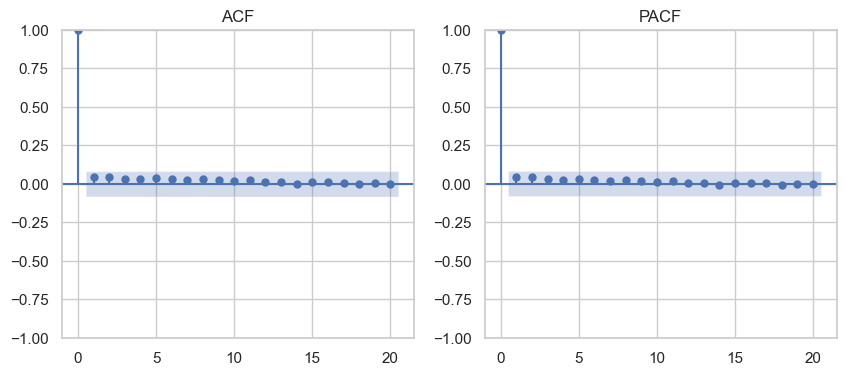

In [218]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

plot_acf(arima_011_y2.resid, lags=20, ax=axes[0]) 
axes[0].set_title("ACF")

plot_pacf(arima_011_y2.resid, lags=20, ax=axes[1]) 
axes[1].set_title("PACF")

plt.show()

# ARIMA(1,1,1)

In [219]:
model = ARIMA(coint_df['y2'].values, order = (1,1,1))
arima_111_y2 = model.fit()
print(arima_111_y2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  575
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -836.216
Date:                Mon, 26 May 2025   AIC                           1678.432
Time:                        17:15:12   BIC                           1691.490
Sample:                             0   HQIC                          1683.525
                                - 575                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7183      0.031     23.336      0.000       0.658       0.779
ma.L1          0.5932      0.036     16.563      0.000       0.523       0.663
sigma2         1.0752      0.063     17.058      0.0

In [220]:
ljung_test = acorr_ljungbox(arima_111_y2.resid, lags=[1,5, 10, 15, 20, 25], return_df=True)
print(ljung_test)

        lb_stat    lb_pvalue
1  0.0060464754 0.9380196930
5  0.3478699411 0.9966446699
10 0.5067960418 0.9999929465
15 0.6578628506 0.9999999873
20 0.7195534994 1.0000000000
25 0.9715185687 1.0000000000


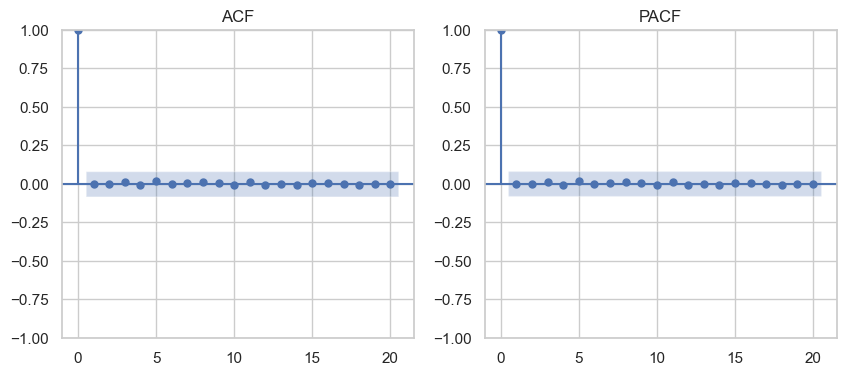

In [221]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

plot_acf(arima_111_y2.resid, lags=20, ax=axes[0]) 
axes[0].set_title("ACF")

plot_pacf(arima_111_y2.resid, lags=20, ax=axes[1]) 
axes[1].set_title("PACF")

plt.show()

# Y10 ARIMA Models

## ARIMA(1,1,0), ARIMA(1,1,1)

In [222]:
model = ARIMA(coint_df['y10'].values, order = (1,1,0))
arima_110_y10 = model.fit()
print(arima_110_y10.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  575
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1284.270
Date:                Mon, 26 May 2025   AIC                           2572.540
Time:                        17:15:13   BIC                           2581.245
Sample:                             0   HQIC                          2575.935
                                - 575                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8586      0.020     42.832      0.000       0.819       0.898
sigma2         5.1274      0.292     17.545      0.000       4.555       5.700
Ljung-Box (L1) (Q):                  35.17   Jarque-

In [223]:
ljung_test = acorr_ljungbox(arima_110_y10.resid, lags=[1,5, 10, 15, 20, 25], return_df=True)
print(ljung_test)

        lb_stat    lb_pvalue
1  1.0417379273 0.3074176202
5  2.0106971855 0.8476629051
10 2.2462406471 0.9940807525
15 2.5209815231 0.9998657715
20 3.1016856800 0.9999945365
25 3.6736850032 0.9999997848


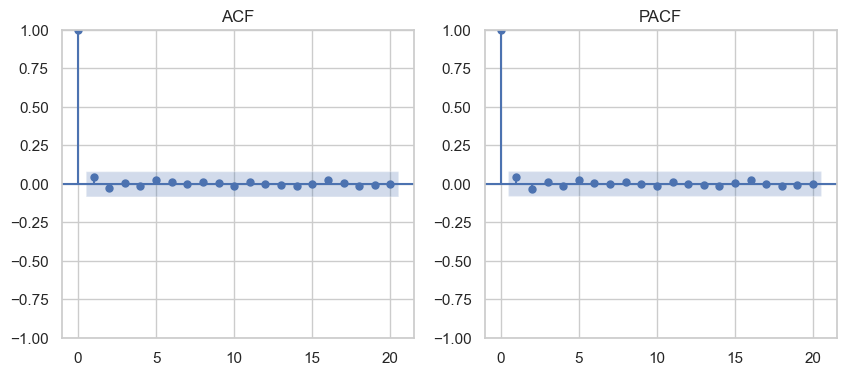

In [224]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

plot_acf(arima_110_y10.resid, lags=20, ax=axes[0]) 
axes[0].set_title("ACF")

plot_pacf(arima_110_y10.resid, lags=20, ax=axes[1]) 
axes[1].set_title("PACF")

plt.show()

# ARIMA(2,1,0)

In [225]:
model = ARIMA(coint_df['y10'].values, order = (2,1,0))
arima_210_y10 = model.fit()
print(arima_210_y10.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  575
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -1259.854
Date:                Mon, 26 May 2025   AIC                           2525.707
Time:                        17:15:13   BIC                           2538.765
Sample:                             0   HQIC                          2530.800
                                - 575                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1042      0.039     28.225      0.000       1.028       1.181
ar.L2         -0.2852      0.039     -7.303      0.000      -0.362      -0.209
sigma2         4.7078      0.272     17.320      0.0

In [226]:
ljung_test = acorr_ljungbox(arima_210_y10.resid, lags=[1,5, 10, 15, 20, 25], return_df=True)
print(ljung_test)

        lb_stat    lb_pvalue
1  0.0493759715 0.8241527089
5  1.8921495896 0.8638578993
10 2.3278573693 0.9931539456
15 2.6500454809 0.9998154223
20 3.0803184874 0.9999948524
25 3.6664913218 0.9999997893


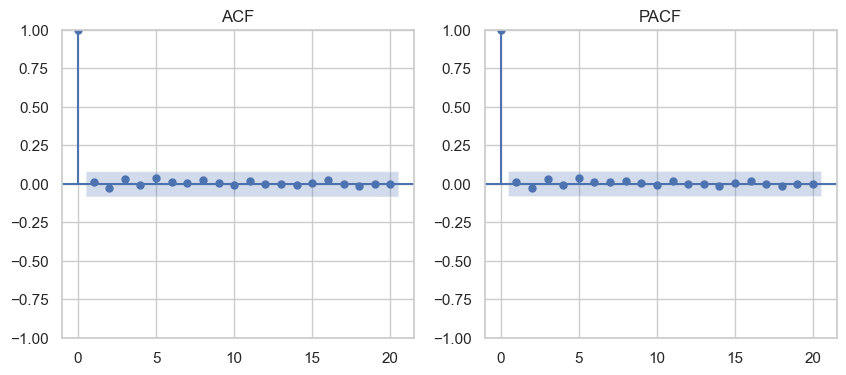

In [227]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

plot_acf(arima_210_y10.resid, lags=20, ax=axes[0]) 
axes[0].set_title("ACF")

plot_pacf(arima_210_y10.resid, lags=20, ax=axes[1]) 
axes[1].set_title("PACF")

plt.show()

#  ARIMA(1,1,1)

In [228]:
model = ARIMA(coint_df['y10'].values, order = (1,1,1))
arima_111_y10 = model.fit()
print(arima_111_y10.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  575
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1242.076
Date:                Mon, 26 May 2025   AIC                           2490.152
Time:                        17:15:14   BIC                           2503.210
Sample:                             0   HQIC                          2495.245
                                - 575                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7278      0.030     23.904      0.000       0.668       0.787
ma.L1          0.5425      0.038     14.237      0.000       0.468       0.617
sigma2         4.4231      0.258     17.169      0.0

In [229]:
ljung_test = acorr_ljungbox(arima_111_y10.resid, lags=[1,5, 10, 15, 20, 25], return_df=True)
print(ljung_test)

        lb_stat    lb_pvalue
1  0.0359825597 0.8495515128
5  1.5343898792 0.9090674374
10 1.9120056738 0.9969711376
15 2.3991609542 0.9999023957
20 2.6676051974 0.9999985298
25 3.4471832001 0.9999998922


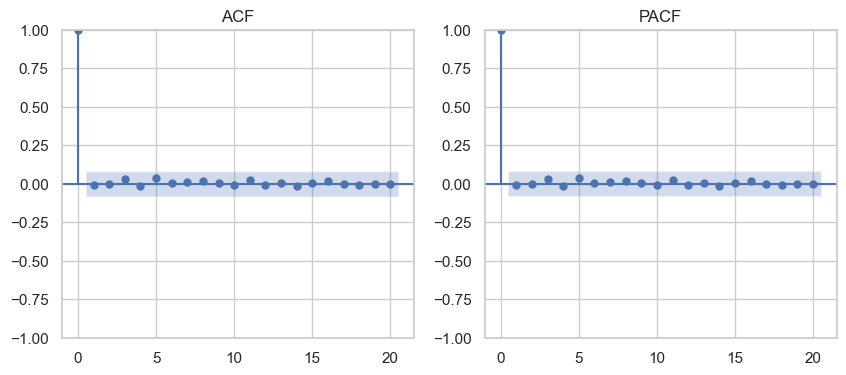

In [230]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

plot_acf(arima_111_y10.resid, lags=20, ax=axes[0]) 
axes[0].set_title("ACF")

plot_pacf(arima_111_y10.resid, lags=20, ax=axes[1]) 
axes[1].set_title("PACF")

plt.show()

In [231]:
models = [arima_110_y2, arima_011_y2, arima_111_y2, arima_110_y10, arima_210_y10, arima_111_y10 ] # list with all the models
names = ['arima_110_y2', 'arima_011_y2', 'arima_111_y2', 'arima_110_y10', 'arima_210_y10', 'arima_111_y10'] # models' names

# Preparing a DataFrame with models sorted by AIC, BIC
results = []
for model, name in zip(models, names):
    results.append([name, round(model.aic,2), round(model.bic,2)])
results_df = pd.DataFrame(results)
results_df.columns = ['model', 'AIC', 'BIC']

print('Models by AIC:\n',results_df.sort_values('AIC'))
print('Models by BIC:\n',results_df.sort_values('BIC'))

Models by AIC:
            model             AIC             BIC
2   arima_111_y2 1678.4300000000 1691.4900000000
0   arima_110_y2 1772.6300000000 1781.3300000000
1   arima_011_y2 1977.1700000000 1985.8800000000
5  arima_111_y10 2490.1500000000 2503.2100000000
4  arima_210_y10 2525.7100000000 2538.7700000000
3  arima_110_y10 2572.5400000000 2581.2500000000
Models by BIC:
            model             AIC             BIC
2   arima_111_y2 1678.4300000000 1691.4900000000
0   arima_110_y2 1772.6300000000 1781.3300000000
1   arima_011_y2 1977.1700000000 1985.8800000000
5  arima_111_y10 2490.1500000000 2503.2100000000
4  arima_210_y10 2525.7100000000 2538.7700000000
3  arima_110_y10 2572.5400000000 2581.2500000000


# Forecast

# Y2

In [232]:
# Forecast for next ten observations (2 working weeks)
forecast_results = arima_111_y2.get_forecast(steps=10)

# Point forecast
forecast_values = forecast_results.predicted_mean

# Confidence (by default 95%) intervals of the point forecast
confidence_intervals = forecast_results.conf_int()

forecast_df = pd.DataFrame({
    "forecast": forecast_values,
    "lower_CI": confidence_intervals[:, 0],
    "upper_CI": confidence_intervals[:, 1],
    "actual y2": coint_test_df['y2'].iloc[:10].values,
}, index= coint_test_df.index[:10])

forecast_df.head()

,forecast,lower_CI,upper_CI,actual y2
575,160.0581845962,158.0258665130,162.0905026795,160.3300000000
576,158.6275448227,153.5090725432,163.7460171022,159.4200000000
577,157.5999746184,149.2382029255,165.9617463113,159.1600000000
578,156.8619128474,145.2984039962,168.4254216986,159.6900000000
579,156.3317931772,141.6940722139,170.9695141406,159.6100000000


In [233]:
final_df = pd.concat([coint_df[['y2']], forecast_df], axis=0)
final_df.tail(15)

,y2,forecast,lower_CI,upper_CI,actual y2
570,166.0000000000,NaN,NaN,NaN,NaN
571,165.7500000000,NaN,NaN,NaN,NaN
572,164.1600000000,NaN,NaN,NaN,NaN
573,163.4700000000,NaN,NaN,NaN,NaN
574,162.0500000000,NaN,NaN,NaN,NaN
575,NaN,160.0581845962,158.0258665130,162.0905026795,160.3300000000
576,NaN,158.6275448227,153.5090725432,163.7460171022,159.4200000000
577,NaN,157.5999746184,149.2382029255,165.9617463113,159.1600000000
578,NaN,156.8619128474,145.2984039962,168.4254216986,159.6900000000
579,NaN,156.3317931772,141.6940722139,170.9695141406,159.6100000000


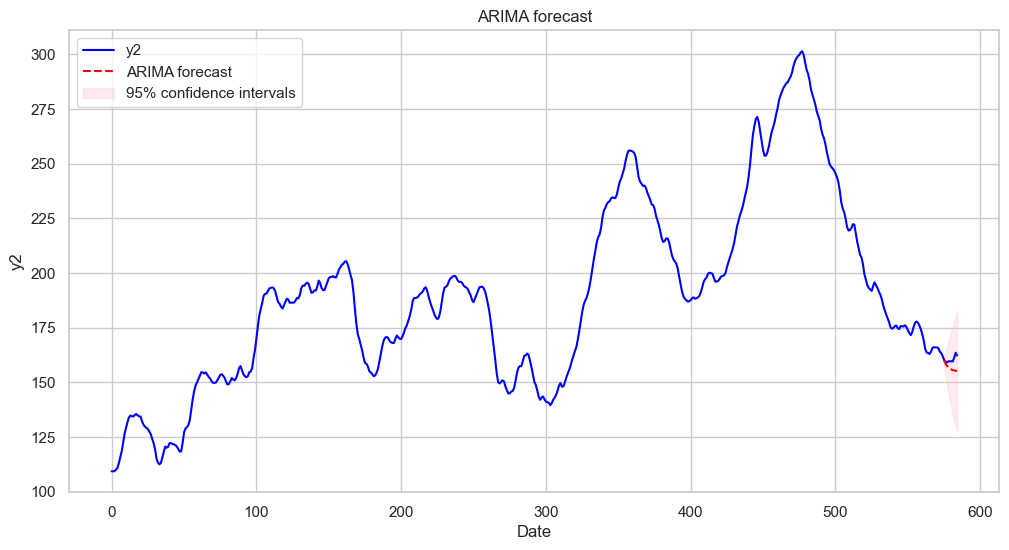

In [234]:
plt.figure(figsize=(12, 6))

# Plot the true values (in-sample + hold-out actuals)
plt.plot(final_df.index,
         final_df["y2"].combine_first(final_df["actual y2"]),
         label="y2",
         color="blue",
         linestyle="-")

# Plot the forecast
plt.plot(final_df.index, 
         final_df["forecast"], 
         label="ARIMA forecast", 
         color="red", 
         linestyle="dashed")

# Plot the confidence intervals
plt.fill_between(final_df.index, 
                 final_df["lower_CI"],
                 final_df["upper_CI"], 
                 color='pink', 
                 alpha=0.3, 
                 label="95% confidence intervals")

plt.title("ARIMA forecast")
plt.xlabel("Date")
plt.ylabel("y2")
plt.legend()
plt.grid(True)

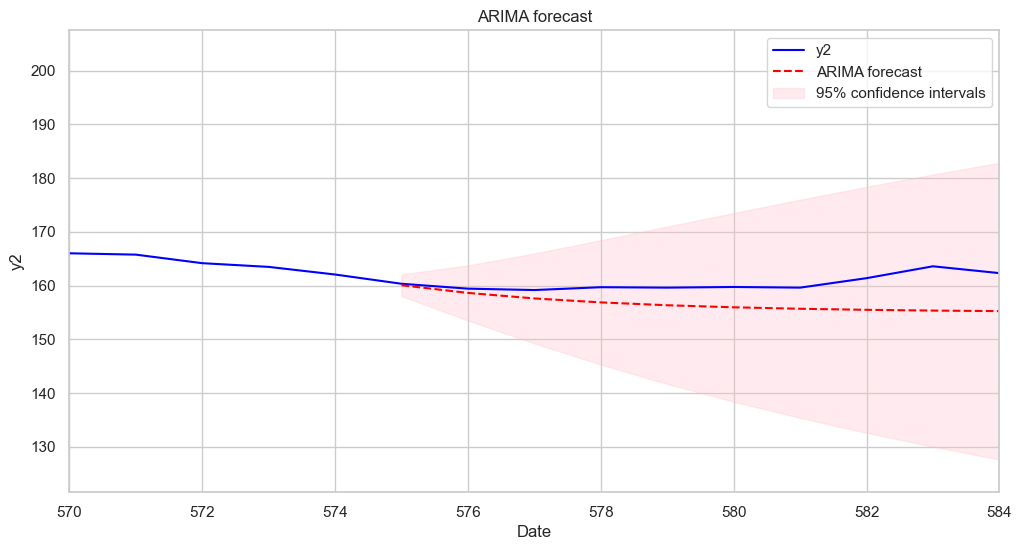

In [235]:
plt.figure(figsize=(12, 6))

# Plot the true values (in-sample + hold-out actuals)
plt.plot(final_df.index,
         final_df["y2"].combine_first(final_df["actual y2"]),
         label="y2",
         color="blue",
         linestyle="-")

# Plot the forecast
plt.plot(final_df.index, 
         final_df["forecast"], 
         label="ARIMA forecast", 
         color="red", 
         linestyle="dashed")

# Plot the confidence intervals
plt.fill_between(final_df.index, 
                 final_df["lower_CI"],
                 final_df["upper_CI"], 
                 color='pink', 
                 alpha=0.3, 
                 label="95% confidence intervals")

plt.title("ARIMA forecast")
plt.xlabel("Date")
plt.ylabel("y2")
plt.legend()
plt.grid(True)

# zoom on last 15 obs
plt.xlim(final_df.index[-15], final_df.index[-1])
plt.ylim(final_df.tail(15)["y2"].min() * 0.75,
         final_df.tail(15)["y2"].max() * 1.25)

plt.show()


In [236]:
# pull out the arrays
true_values     = forecast_df["actual y2"].values     
forecast_values = forecast_df["forecast"].values
n               = len(forecast_values)

# 1. MAE
mae  = np.mean(np.abs(true_values - forecast_values))

# 2. RMSE
rmse = np.sqrt(np.mean((true_values - forecast_values)**2))

# 3. MAPE
mape = np.mean(np.abs((true_values - forecast_values) / true_values)) * 100

# 4. AMAPE
epsilon = 1e-8
amape   = np.mean(np.abs((true_values - forecast_values) / (np.abs(true_values) + epsilon))) * 100

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"AMAPE:{amape:.2f}%")

MAE:  3.76
RMSE: 4.52
MAPE: 2.33%
AMAPE:2.33%


# Y10

In [237]:
# Forecast for next ten observations (2 working weeks)
forecast_results = arima_111_y10.get_forecast(steps=10)

# Point forecast
forecast_values = forecast_results.predicted_mean

# Confidence (by default 95%) intervals of the point forecast
confidence_intervals = forecast_results.conf_int()

forecast_df = pd.DataFrame({
    "forecast": forecast_values,
    "lower_CI": confidence_intervals[:, 0],
    "upper_CI": confidence_intervals[:, 1],
    "actual y10": coint_test_df['y10'].iloc[:10].values,
}, index= coint_test_df.index[:10])

forecast_df.head()

,forecast,lower_CI,upper_CI,actual y10
575,221.0881467605,216.9661219766,225.2101715444,221.3900000000
576,218.3938749739,208.1679984889,228.6197514588,219.6400000000
577,216.4329381159,199.7596192083,233.1062570235,218.7400000000
578,215.0057348991,191.9366929115,238.0747768867,219.9300000000
579,213.9669921095,184.7298899302,243.2040942887,219.8100000000


In [238]:
final_df = pd.concat([coint_df[['y10']], forecast_df], axis=0)
final_df.tail(15)

,y10,forecast,lower_CI,upper_CI,actual y10
570,232.5900000000,NaN,NaN,NaN,NaN
571,232.0900000000,NaN,NaN,NaN,NaN
572,228.8800000000,NaN,NaN,NaN,NaN
573,227.5700000000,NaN,NaN,NaN,NaN
574,224.7900000000,NaN,NaN,NaN,NaN
575,NaN,221.0881467605,216.9661219766,225.2101715444,221.3900000000
576,NaN,218.3938749739,208.1679984889,228.6197514588,219.6400000000
577,NaN,216.4329381159,199.7596192083,233.1062570235,218.7400000000
578,NaN,215.0057348991,191.9366929115,238.0747768867,219.9300000000
579,NaN,213.9669921095,184.7298899302,243.2040942887,219.8100000000


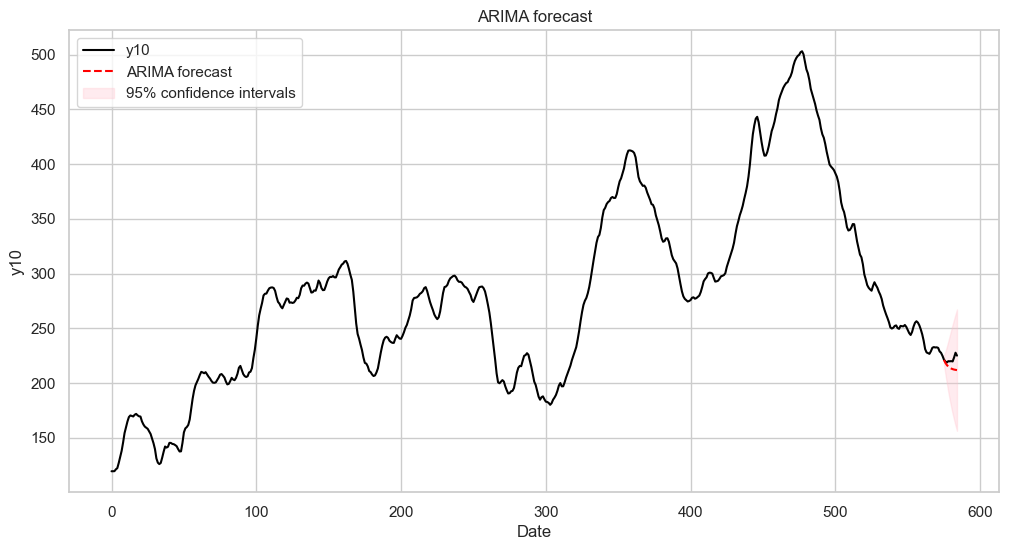

In [239]:
plt.figure(figsize=(12, 6))

# Plot the true values (in-sample + hold-out actuals)
plt.plot(final_df.index,
         final_df["y10"].combine_first(final_df["actual y10"]),
         label="y10",
         color="black",
         linestyle="-")

# Plot the forecast
plt.plot(final_df.index, 
         final_df["forecast"], 
         label="ARIMA forecast", 
         color="red", 
         linestyle="dashed")

# Plot the confidence intervals
plt.fill_between(final_df.index, 
                 final_df["lower_CI"],
                 final_df["upper_CI"], 
                 color='pink', 
                 alpha=0.3, 
                 label="95% confidence intervals")

plt.title("ARIMA forecast")
plt.xlabel("Date")
plt.ylabel("y10")
plt.legend()
plt.grid(True)

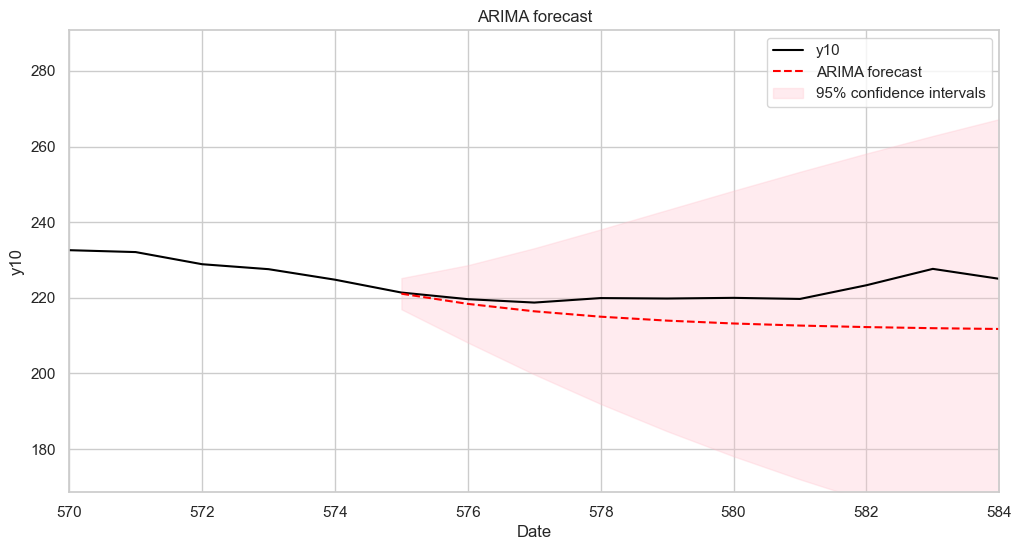

In [240]:
plt.figure(figsize=(12, 6))

# Plot the true values (in-sample + hold-out actuals)
plt.plot(final_df.index,
         final_df["y10"].combine_first(final_df["actual y10"]),
         label="y10",
         color="black",
         linestyle="-")

# Plot the forecast
plt.plot(final_df.index, 
         final_df["forecast"], 
         label="ARIMA forecast", 
         color="red", 
         linestyle="dashed")

# Plot the confidence intervals
plt.fill_between(final_df.index, 
                 final_df["lower_CI"],
                 final_df["upper_CI"], 
                 color='pink', 
                 alpha=0.3, 
                 label="95% confidence intervals")

plt.title("ARIMA forecast")
plt.xlabel("Date")
plt.ylabel("y10")
plt.legend()
plt.grid(True)

# zoom on last 15 obs
plt.xlim(final_df.index[-15], final_df.index[-1])
plt.ylim(final_df.tail(15)["y10"].min() * 0.75,
         final_df.tail(15)["y10"].max() * 1.25)

plt.show()


In [241]:
# pull out the arrays
true_values     = forecast_df["actual y10"].values     
forecast_values = forecast_df["forecast"].values
n               = len(forecast_values)

# 1. MAE
mae  = np.mean(np.abs(true_values - forecast_values))

# 2. RMSE
rmse = np.sqrt(np.mean((true_values - forecast_values)**2))

# 3. MAPE
mape = np.mean(np.abs((true_values - forecast_values) / true_values)) * 100

# 4. AMAPE
epsilon = 1e-8
amape   = np.mean(np.abs((true_values - forecast_values) / (np.abs(true_values) + epsilon))) * 100

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"AMAPE:{amape:.2f}%")

MAE:  6.84
RMSE: 8.40
MAPE: 3.07%
AMAPE:3.07%
